In [ ]:
# ............ start with filtered data ............ #

In [2]:
library(SingleCellExperiment)
library(Matrix)
library(MetaNeighbor)
library(MetaMarkers)
library(scater)

In [3]:
barcodes = read.delim('barcodes.tsv', sep = '\t', header = FALSE)
features = read.delim('features.tsv', sep = '\t', header = FALSE) # genes and peaks
colnames(barcodes) <- 'label'
colnames(features) <- c('Gene', 'Symbol', 'DataType', 'chr', 'chr_start', 'chr_end')

# load matrix
mtx = readMM('matrix.mtx')
rownames(mtx) <- features[,1]
colnames(mtx) <- unlist(barcodes)

# load cell-type annotation
clusters = read.delim('clustering/clusters.csv', sep = ',')
clusters$Cluster <- paste0('cluster_', clusters$Cluster)
clusters$Dataset <- rep('human_embryo', dim(clusters)[1])
pca = read.delim('dimensionality_reduction/pca_projection.csv', sep = ',')
tsne = read.delim('dimensionality_reduction/tsne_projection.csv', sep = ',')
umap = read.delim('dimensionality_reduction/umap_projection.csv', sep = ',')

In [4]:
# convert to SCE object
mat1 <- SingleCellExperiment(list(counts=mtx), colData=cbind(clusters, pca[,2:11], tsne[,2:3], umap[,2:3]), rowData=features)
mat1$Cluster <- as.factor(mat1$Cluster)

In [5]:
dim(mat1)
mat1[1:4,1:2]

[1] 231531  19764

class: SingleCellExperiment 
dim: 4 2 
metadata(0):
assays(1): counts
rownames(4): ENSG00000243485 ENSG00000237613 ENSG00000186092
  ENSG00000238009
rowData names(6): Gene Symbol ... chr_start chr_end
colnames(2): AAACAGCCAAGCCACT-1 AAACAGCCAAGGTATA-1
colData names(17): Barcode Cluster ... UMAP.1 UMAP.2
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):

In [10]:
save(mat1, file = 'human_embryo_filtered_SCE.Rdata')

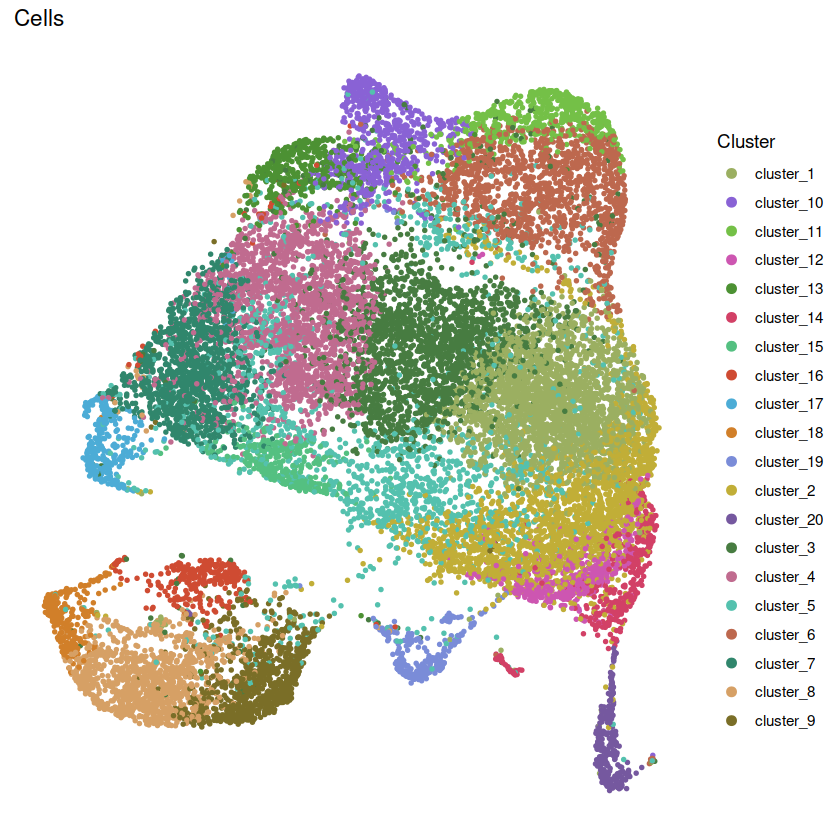

In [77]:
# plot PC, tsne and umaps for 20k cells
library(SCEUtils)

# png('human_embryo_filtered_umap.png', width = 10, height = 10, res = 300, units = 'in')
scatter_plot_sce(mat1, mat1$UMAP.1, mat1$UMAP.2, color = 'Cluster', palette = c("#9baf61","#8962d5","#74c047",
"#cd56b1","#4c9133","#d24066","#54c081","#cf4b32","#4cacd6","#d17f29","#7a8cd8","#c1ae37","#75589f","#477c41","#c06b8f","#54c1ae","#bd684e","#30866c","#d6a065","#7a6e27"))
# dev.off()

In [6]:
table(rowData(mat1)['DataType'])

# subset to gene expression data
mat1 <- mat1[1:36601,]
assay(mat1, "cpm") = convert_to_cpm(assay(mat1))


Gene Expression           Peaks 
          36601          194930 

Warning message in recycleSingleBracketReplacementValue(value, x):
“number of values supplied is not a sub-multiple of the number of values to be replaced”


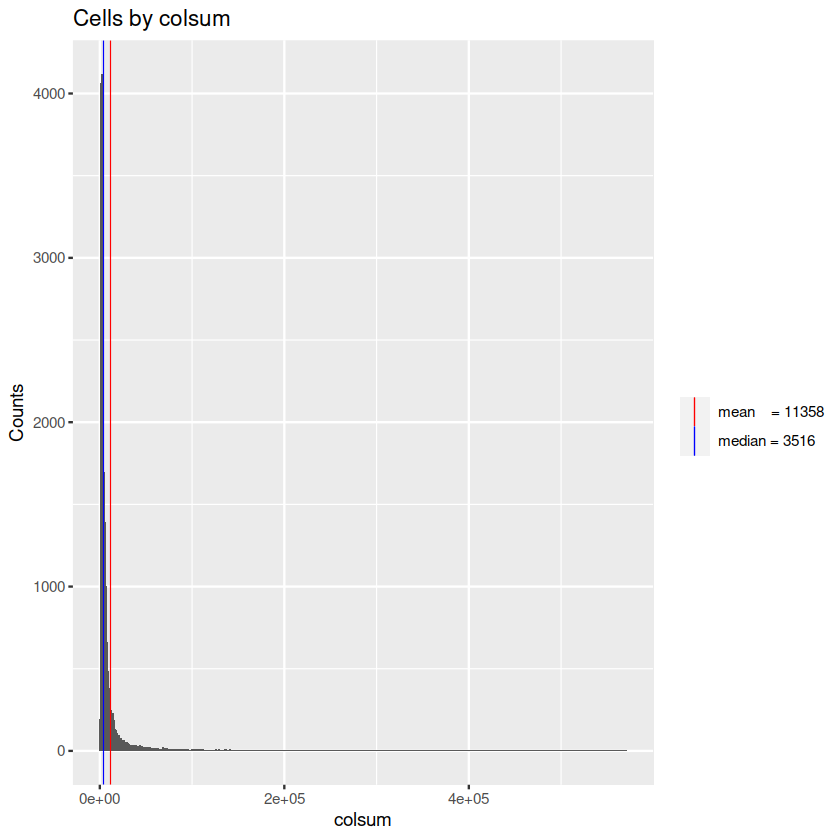

In [38]:
# QC, MetaNeighbor
library(SCEUtils)

smat = SingleCellExperiment::counts(mat1)
rsum = rowSums(smat)
colData(mat1)['rowsum'] <- rsum

csum = colSums(smat)
colData(mat1)['colsum'] <- csum

metadata_histogram(mat1, x = 'colsum', bins = 500)

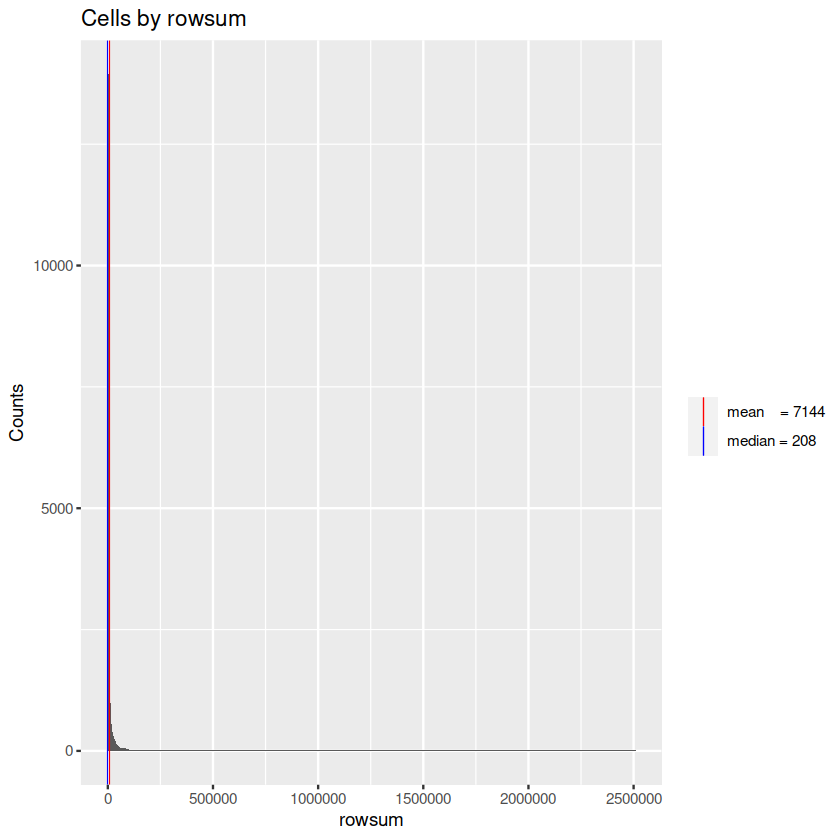

In [42]:
# png('sn10x-cell-counts.png', width = 10, height = 10, units = 'in', res = 300)
metadata_histogram(mat1, x = 'rowsum', bins = 500)
# dev.off()

In [7]:
start.time <- Sys.time()
hvg = variableGenes(mat1, exp_labels = mat1$Cluster)
# defaults to top 95% of genes. May need to vary
end.time <- Sys.time()
time.taken <- end.time - start.time
time.taken

length(hvg)

Time difference of 1.538686 mins

[1] 419

In [14]:
# ................  MN unsupervised, one-vs-all, fast version ................ #
# split by species,   symmetric T (for calc scores) and F (find poor groups)
start.time <- Sys.time()

cls_best = MetaNeighborUS(var_genes = hvg, dat = mat1, study_id = mat1$Dataset, 
    cell_type = mat1$Cluster, fast_version = TRUE, one_vs_best = TRUE,
    symmetric_output = FALSE)

cls_all = MetaNeighborUS(var_genes = hvg, dat = mat1, study_id = mat1$Dataset, 
    cell_type = mat1$Cluster, fast_version = TRUE, one_vs_best = FALSE,
    symmetric_output = FALSE)


end.time <- Sys.time()
time.taken <- end.time - start.time
time.taken

Time difference of 6.83876 secs

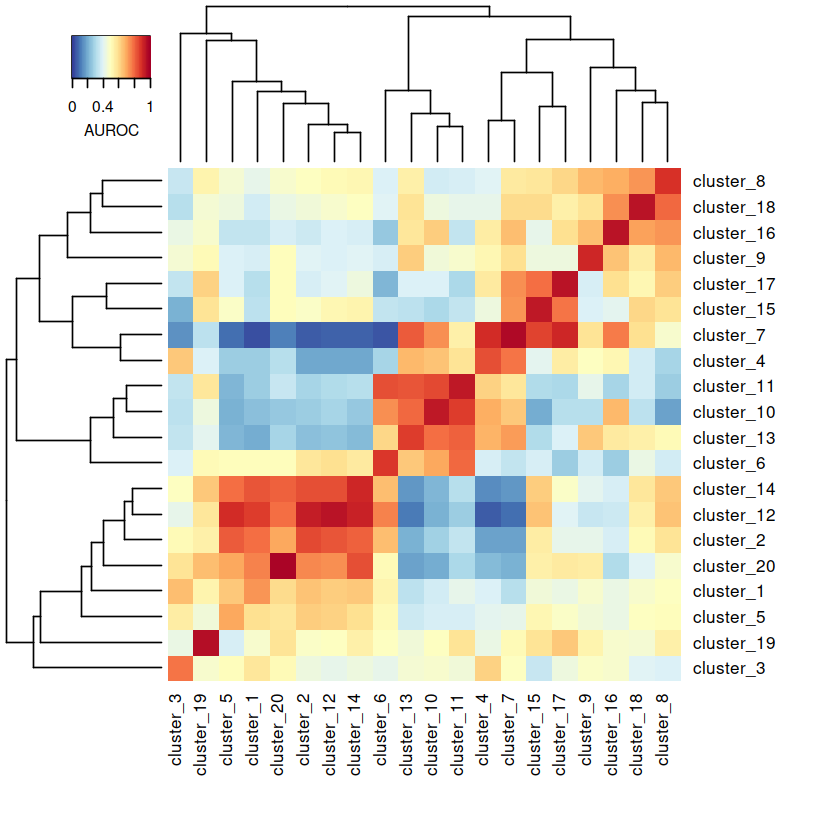

In [35]:
# png('human_embryo_cls_allvsall.png', width = 10, height = 10, res = 300, units = 'in')
currmat = cls_all
rownames(currmat) <- sub(".*\\|", "", rownames(cls_best))
colnames(currmat) = rownames(currmat)
plotHeatmap(currmat, cex = 1)
# dev.off()

In [8]:
mat1$cell_type = mat1$Cluster

In [33]:
# gene set enrichment of hvg
source('gene_set_enrichment.R')

In [34]:
gse = gene_set_enrichment(hvg, 'human')
gse$description[gse$sig==TRUE][1:10]
head(gse)

[1] "mitochondrial protein complex"                 
 [2] "mitochondrial inner membrane"                  
 [3] "organelle inner membrane"                      
 [4] "mitochondrial envelope"                        
 [5] "mitochondrial membrane"                        
 [6] "generation of precursor metabolites and energy"
 [7] "inner mitochondrial membrane protein complex"  
 [8] NA                                              
 [9] NA                                              
[10] NA

GO_term    description                                    N_sample
GO:0098798 GO:0098798 mitochondrial protein complex                  33      
GO:0005743 GO:0005743 mitochondrial inner membrane                   35      
GO:0019866 GO:0019866 organelle inner membrane                       36      
GO:0005740 GO:0005740 mitochondrial envelope                         42      
GO:0031966 GO:0031966 mitochondrial membrane                         40      
GO:0006091 GO:0006091 generation of precursor metabolites and energy 28      
           N_univ pvals        adj_pvals    sig 
GO:0098798 302    2.524793e-17 2.269789e-13 TRUE
GO:0005743 557    4.016036e-11 1.805208e-07 TRUE
GO:0019866 628    2.673437e-10 8.011401e-07 TRUE
GO:0005740 861    1.141297e-09 2.565064e-06 TRUE
GO:0031966 812    2.211251e-09 3.392126e-06 TRUE
GO:0006091 435    2.263933e-09 3.392126e-06 TRUE

In [43]:
grep('mt', rowData(mat1)[match(hvg, rowData(mat1)[,1]),2])

integer(0)

In [44]:
table(mat1$Cluster)


 cluster_1 cluster_10 cluster_11 cluster_12 cluster_13 cluster_14 cluster_15 
      2504        723        547        519        472        416        338 
cluster_16 cluster_17 cluster_18 cluster_19  cluster_2 cluster_20  cluster_3 
       325        317        300        292       2217        284       2127 
 cluster_4  cluster_5  cluster_6  cluster_7  cluster_8  cluster_9 
      2038       1566       1428       1362       1114        875 

[1] 7384.887

[1] 7410

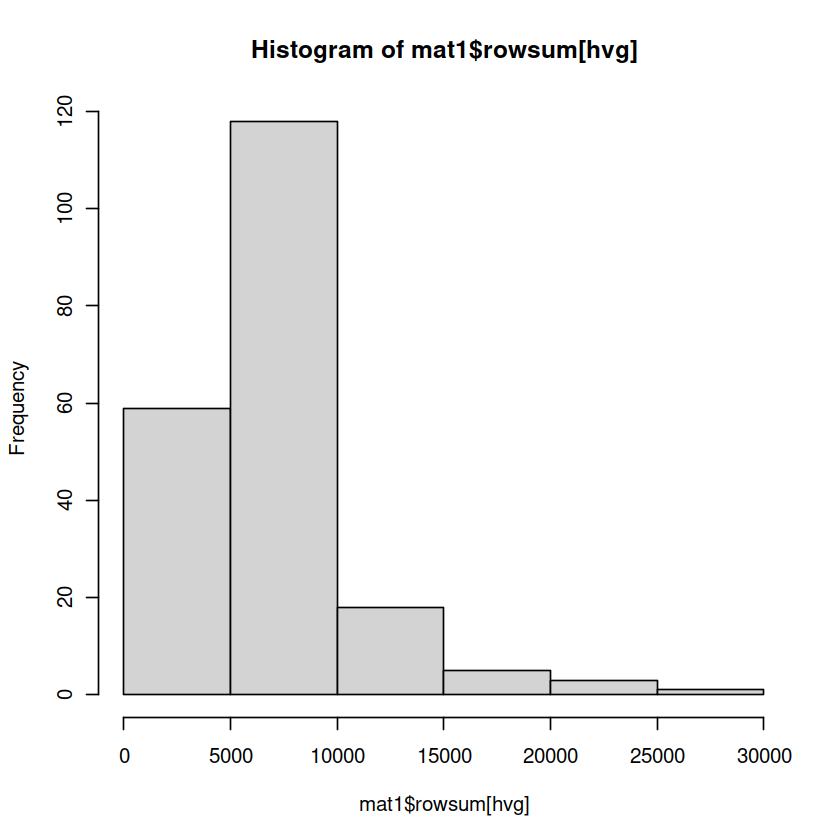

In [47]:
hist(mat1$rowsum[hvg])
mean(mat1$rowsum[hvg], na.rm = T)
median(mat1$rowsum[hvg], na.rm = T)

In [89]:
# save files
write.table(cls_best, file = 'human_embryo_MN_cluster_1vbest_aurocs.csv', 
            sep = ',', row.names = F, col.names = T, quote = F)
write.table(cls_all, file = 'human_embryo_MN_metacell_1vbest_aurocs.csv', 
            sep = ',', row.names = F, col.names = T, quote = F)

In [19]:
# top hits for cross-species or cross-dataset
# options(warn = -1)
# tophits1 = topHits(cls_best, dat = mat1, study_id = mat1$Dataset,
#                            cell_type = mat1$Cluster, threshold = 0.6)

In [10]:
# human adult heart cell atlas from Teichmann lab paper
library(zellkonverter)
library(plyr)

In [11]:
aa = readH5AD('~/heart/global_raw.h5ad')  # aa = readH5AD('TS_Liver.h5ad')
assay(aa, 'raw_counts') <- NULL
assay(aa, 'decontXcounts') <- NULL
assay(aa, 'counts') <- assay(aa, 'X')
assay(aa, 'X') <- NULL
colData(aa)$Dataset = 'human_heart_atlas'

aa = aa[,which(aa$cell_type!='NotAssigned')]
aa = aa[,which(aa$cell_type!='doublets')]
# assay(aa, "cpm") = convert_to_cpm(assay(aa))

In [39]:
dim(aa)
typeof(aa)

[1]  33538 486134

[1] "S4"

In [45]:
colData(aa)

DataFrame with 486134 rows and 19 columns
                                        NRP age_group    cell_source
                                   <factor>  <factor>       <factor>
AAACCCAAGAACGCGT-1-H0015_apex            No     50-55 Harvard-Nuclei
AAACCCAAGCAAACAT-1-H0015_apex            No     50-55 Harvard-Nuclei
AAACCCAAGCTACTGT-1-H0015_apex            No     50-55 Harvard-Nuclei
AAACCCAGTACCGCGT-1-H0015_apex            No     50-55 Harvard-Nuclei
AAACCCATCAAACCCA-1-H0015_apex            No     50-55 Harvard-Nuclei
...                                     ...       ...            ...
TTTGTTGTCATACGGT-1-HCAHeart8102862      Yes     60-65    Sanger-CD45
TTTGTTGTCCTACCAC-1-HCAHeart8102862      Yes     60-65    Sanger-CD45
TTTGTTGTCGACGCTG-1-HCAHeart8102862      Yes     60-65    Sanger-CD45
TTTGTTGTCGGCTGAC-1-HCAHeart8102862      Yes     60-65    Sanger-CD45
TTTGTTGTCGGTGTTA-1-HCAHeart8102862      Yes     60-65    Sanger-CD45
                                                   cell_type 

In [12]:
# get highly variable genes for MN
hvgh = variableGenes(aa, exp_labels = aa$cell_type)
length(hvgh)

[1] 3366

In [87]:
gse = gene_set_enrichment(rowData(aa)[hvgh,1], 'human')
gse$description[gse$sig==TRUE][1:10]
head(gse)

[1] "cellular protein catabolic process"                        
 [2] "nuclear body"                                              
 [3] "transferase complex"                                       
 [4] "proteolysis involved in cellular protein catabolic process"
 [5] "modification-dependent macromolecule catabolic process"    
 [6] "protein catabolic process"                                 
 [7] "regulation of cellular catabolic process"                  
 [8] "modification-dependent protein catabolic process"          
 [9] "ubiquitin-dependent protein catabolic process"             
[10] "viral process"

GO_term   
GO:0044257 GO:0044257
GO:0016604 GO:0016604
GO:1990234 GO:1990234
GO:0051603 GO:0051603
GO:0043632 GO:0043632
GO:0030163 GO:0030163
           description                                                N_sample
GO:0044257 cellular protein catabolic process                         252     
GO:0016604 nuclear body                                               300     
GO:1990234 transferase complex                                        283     
GO:0051603 proteolysis involved in cellular protein catabolic process 241     
GO:0043632 modification-dependent macromolecule catabolic process     229     
GO:0030163 protein catabolic process                                  261     
           N_univ pvals        adj_pvals    sig 
GO:0044257 708    5.660452e-49 5.088746e-45 TRUE
GO:0016604 929    3.496882e-48 1.571848e-44 TRUE
GO:1990234 858    1.906121e-47 5.712009e-44 TRUE
GO:0051603 674    3.088598e-47 5.773548e-44 TRUE
GO:0043632 623    3.211095e-47 5.773548e-44 TRUE
GO:0030163 773    7.733362e-46 1.158715e-42 TRUE

In [48]:
start.time <- Sys.time()

cell1 = MetaNeighborUS(var_genes = hvgh, dat = aa, study_id = aa$Dataset, 
    cell_type = aa$cell_type, fast_version = TRUE, one_vs_best = TRUE,
    symmetric_output = FALSE)

cell2 = MetaNeighborUS(var_genes = hvgh, dat = aa, study_id = aa$Dataset, 
    cell_type = aa$cell_type, fast_version = TRUE, one_vs_best = FALSE,
    symmetric_output = FALSE)


end.time <- Sys.time()
time.taken <- end.time - start.time
time.taken

Time difference of 4.177787 mins

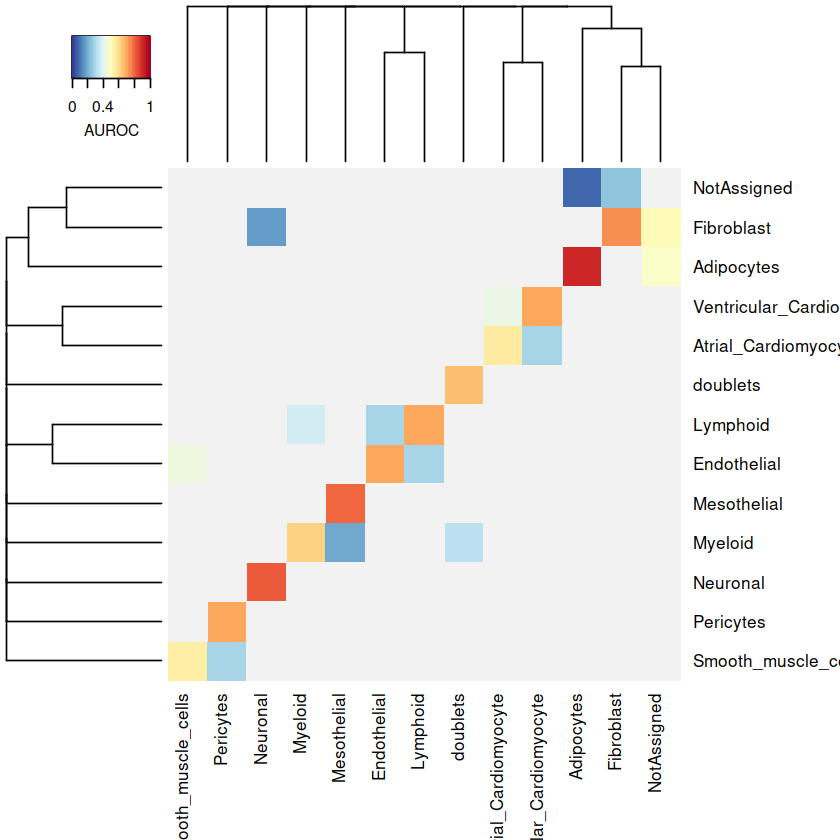

In [53]:
# png('human_heart_atlas_celltype_1vsbest.png', width = 10, height = 10, res = 300, units = 'in')
currmat = cell1
rownames(currmat) <- sub(".*\\|", "", rownames(cell1))
colnames(currmat) = rownames(currmat)
plotHeatmap(currmat, cex = 1)
# dev.off()

In [12]:
currgenes = hvg[which(!is.na(match(hvg, rowData(aa)[,1])))]
new1 = mat1[match(currgenes, rownames(mat1)),]
new2 = aa[match(currgenes, rowData(aa)[,1]),which(aa$cell_type!='NotAssigned')]
new2 = new2[,which(new2$cell_type!='doublets')]
rownames(new1) = currgenes
rownames(new2) = currgenes
colData(new1) <- colData(new1)[c('Dataset', 'cell_type')]
colData(new1)$Dataset <- as.factor(colData(new1)$Dataset)
assay(new1, 'cpm') <- NULL

In [17]:
dim(aa)
dim(new2)

[1]  33538 486134

[1]    416 452136

In [20]:
table(new2$cell_type)


               Adipocytes      Atrial_Cardiomyocyte               Endothelial 
                     3799                     23483                    100579 
               Fibroblast                  Lymphoid               Mesothelial 
                    59341                     17217                       718 
                  Myeloid                  Neuronal               NotAssigned 
                    23028                      3961                         0 
                Pericytes       Smooth_muscle_cells Ventricular_Cardiomyocyte 
                    77856                     16242                    125289 
                 doublets 
                        0 

In [19]:
# celltypes1 = c('Ventricular_Cardiomyocyte', 'Atrial_Cardiomyocyte')
# celltypes1 = c('Endothelial', 'Lymphoid')
# celltypes1 = c('Myeloid', 'Mesothelial')
# celltypes1 = c('Adipocytes', 'Fibroblast')
# celltypes1 = c('Neuronal', 'Pericytes', 'Smooth_muscle_cells')
celltypes1 = c('Ventricular_Cardiomyocyte', 'Atrial_Cardiomyocyte', 'Endothelial', 'Lymphoid', 'Myeloid', 'Mesothelial',
              'Adipocytes', 'Fibroblast', 'Neuronal', 'Pericytes', 'Smooth_muscle_cells')   # all cell types

new3 = new2[,which(new2$cell_type %in% celltypes1)]
colData(new3) <- colData(new3)[c('Dataset', 'cell_type')]
colData(new3)$Dataset <- as.factor(colData(new3)$Dataset)
int_colData(new3)$reducedDims <- int_colData(new3)$altExps

dim(new3)

[1]    416 451513

In [20]:
newmat = cbind(new1, new3)
dim(newmat)

[1]    416 471277

In [21]:
start.time <- Sys.time()

auroc1 = MetaNeighborUS(var_genes = currgenes, dat = newmat, study_id = newmat$Dataset, 
    cell_type = newmat$cell_type, fast_version = TRUE, one_vs_best = TRUE,
    symmetric_output = FALSE)

auroc2 = MetaNeighborUS(var_genes = currgenes, dat = newmat, study_id = newmat$Dataset, 
    cell_type = newmat$cell_type, fast_version = TRUE, one_vs_best = FALSE,
    symmetric_output = FALSE)


end.time <- Sys.time()
time.taken <- end.time - start.time
time.taken

Time difference of 30.68936 secs

In [23]:
png('embryo_HHCA_ALL_1vsbest.png', width = 10, height = 10, res = 300, units = 'in')
currmat = auroc1
rownames(currmat) <- sub(".*\\|", "", rownames(auroc1))
colnames(currmat) = rownames(currmat)
MetaNeighbor::plotHeatmap(currmat, cex = 1)
dev.off()

png('embryo_HHCA_ALL_allvsall.png', width = 10, height = 10, res = 300, units = 'in')
currmat = auroc2
rownames(currmat) <- sub(".*\\|", "", rownames(auroc1))
colnames(currmat) = rownames(currmat)
MetaNeighbor::plotHeatmap(currmat, cex = 1)
dev.off()

png 
  2

png 
  2

Warning message in recycleSingleBracketReplacementValue(value, x):
“number of values supplied is not a sub-multiple of the number of values to be replaced”


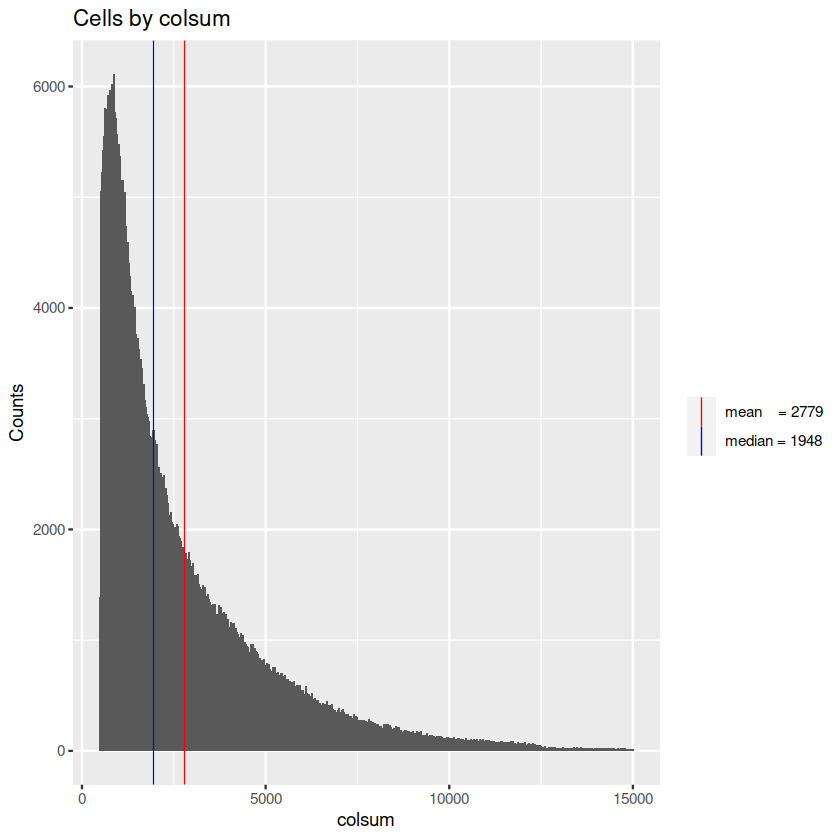

In [24]:
# heart atlas coverage
# QC, MetaNeighbor
library(SCEUtils)

smat = SingleCellExperiment::counts(aa)
rsum = rowSums(smat)
colData(aa)['rowsum'] <- rsum

csum = colSums(smat)
colData(aa)['colsum'] <- csum

# png('hhca_coverage.png', width = 5, height = 5, res = 300, units = 'in')
metadata_histogram(aa, x = 'colsum', bins = 500)
# dev.off()